In [1]:
library(JGL)
library(ggplot2)
library(patchwork)
library(pROC)
library(ggnewscale)
library(latex2exp)
options(warn=-1)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




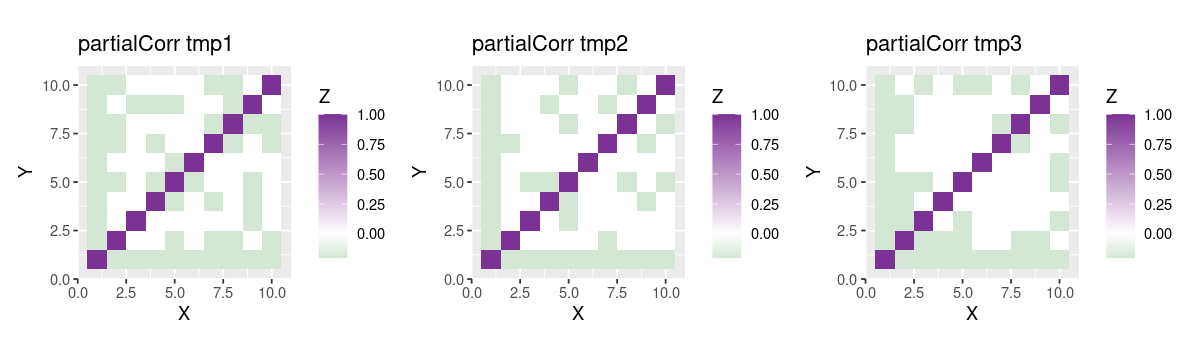

In [2]:
rm(list = ls())
source('../tools.R')
source('../FLAG.R')
set.seed(1)

get.pc.true <- function(p, sparsity, value=-0.2){
  sparse = rbinom(p*p,1,1-sparsity)*value
  pc = matrix(sparse, p, p)
  pc[,1] = value
  pc[upper.tri(pc)] = t(pc)[upper.tri(pc)]
  diag(pc) = 1
  pc
}

p=10
tmp1 = get.pc.true(p, 0.7)
options(repr.plot.width=10, repr.plot.height=3)
X=Y=1:p
df=expand.grid(X=X, Y=Y)
df$Z=c(tmp1)
p1=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('partialCorr tmp1') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-0.2, 1))

tmp2 = get.pc.true(p, 0.7)
tmp3 = get.pc.true(p, 0.7)
df$Z=c(tmp2)
p2=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('partialCorr tmp2') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-0.2, 1))
df$Z=c(tmp3)
p3=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('partialCorr tmp3') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-0.2, 1))
p1+p2+p3

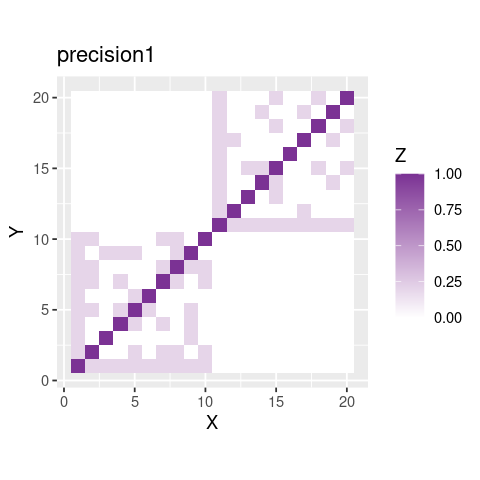

In [3]:
P = 2*p
sigma.list = c(rep(1,P))
pc1 = matrix(0, P, P)
pc1[1:p, 1:p] = tmp1
pc1[(p+1):P, (p+1):P] = tmp2
Pre1 = -diag(sigma.list) %*% pc1 %*% diag(sigma.list)
diag(Pre1) = -diag(Pre1)
options(repr.plot.width=4, repr.plot.height=4)
X=Y=1:P
df=expand.grid(X=X, Y=Y)
df$Z=c(Pre1)
ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('precision1') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(0, 1))

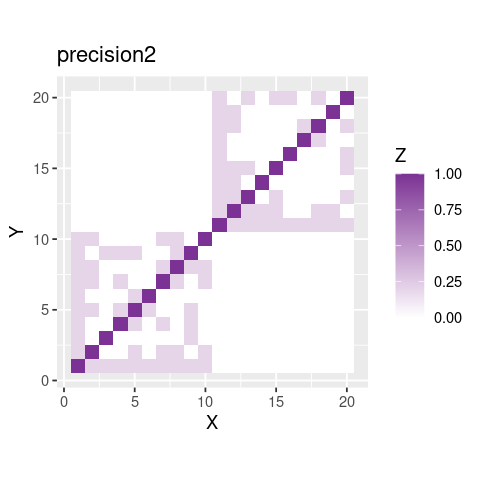

In [4]:
pc2 = matrix(0, P, P)
pc2[1:p, 1:p] = tmp1
pc2[(p+1):P, (p+1):P] = tmp3
Pre2 = -diag(sigma.list) %*% pc2 %*% diag(sigma.list)
diag(Pre2) = -diag(Pre2)
options(repr.plot.width=4, repr.plot.height=4)
X=Y=1:P
df=expand.grid(X=X, Y=Y)
df$Z=c(Pre2)
ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('precision2') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(0, 1))

In [5]:
Pre1.adj = get.adj(Pre1)
Pre2.adj = get.adj(Pre2)
Sigma1 = solve(Pre1)
Sigma2 = solve(Pre2)
N1 = 100
N2 = 160
# Z1 = MASS::mvrnorm(N1, rep(0, P), Sigma1)
# Z1 = scale(Z1, center = T, scale = F)
# Z2 = MASS::mvrnorm(N2, rep(0, P), Sigma2)
# Z2 = scale(Z2, center = T, scale = F)
# S1 = cov(Z1)
# S2 = cov(Z2)

In [6]:
get.meta<-function(P, om1, om2){
#   test.pval.list = c()
#   meta.pval.list = c()
#   res = NULL
#   om.meta.rho = matrix(0, P, P)
#   om.meta.rho.se = matrix(0, P, P)
  om.meta.rho.pval = matrix(0, P, P)
  om.meta.prec1 = diag( diag(om1$precision.est) )
  om.meta.prec2 = diag( diag(om2$precision.est) )
  for(i in 1:(P-1)){
    for(j in (i+1):P){
      rho1 = om1$rho.est[i,j]
      rho2 = om2$rho.est[i,j]
      rho.se1 = om1$rho.se[i,j]
      rho.se2 = om2$rho.se[i,j]
      rho.pval1 = om1$partialcor.pval[i,j]
      rho.pval2 = om2$partialcor.pval[i,j]
      test.stat = (rho1 - rho2) / sqrt( rho.se1^2 + rho.se2^2 )
      test.pval = pchisq(test.stat^2, 1, lower.tail = F)
#       test.pval.list = c(test.pval.list, test.pval)
      if(is.na(test.pval)==TRUE | test.pval<0.05){
        meta.rho = NaN
        meta.rho.se = NaN
        meta.rho.pval = NaN
        om.meta.prec1[i,j] = om.meta.prec1[j,i] = om1$precision.est[i,j]
        om.meta.prec2[i,j] = om.meta.prec2[j,i] = om2$precision.est[i,j]
      }
      else{
        rho.list = c(rho1, rho2)
        w.list = c( 1/(rho.se1^2), 1/(rho.se2^2) )
        w.sum = sum(w.list)
        meta.rho = sum(w.list * rho.list) / w.sum
        meta.rho.se = 1 / sqrt(w.sum)
        meta.rho.pval = pchisq((meta.rho / meta.rho.se)^2, 1, lower.tail = F)
        eta1 = meta.rho * sqrt(om1$sigma.a2[i,j]) * sqrt(om1$sigma.b2[i,j])
        eta2 = meta.rho * sqrt(om2$sigma.a2[i,j]) * sqrt(om2$sigma.b2[i,j])
        prec1 = solve( matrix(c(om1$sigma.a2[i,j], eta1, eta1, om1$sigma.b2[i,j]), 2, 2) )
        prec2 = solve( matrix(c(om2$sigma.a2[i,j], eta2, eta2, om2$sigma.b2[i,j]), 2, 2) )
        om.meta.prec1[i,j] = om.meta.prec1[j,i] = prec1[1,2]
  #       cat('om1', om1$precision.est[i,j], prec1[1,2])
        om.meta.prec2[i,j] = om.meta.prec2[j,i] = prec2[1,2]
  #       cat('\tom2', om2$precision.est[i,j], prec2[1,2], '\n')
      }
#       om.meta.rho[i,j] = om.meta.rho[j,i] = meta.rho
#       om.meta.rho.se[i,j] = om.meta.rho.se[j,i] = meta.rho.se
      om.meta.rho.pval[i,j] = om.meta.rho.pval[j,i] = meta.rho.pval
#       meta.pval.list = c(meta.pval.list, meta.rho.pval)

#       res0 = data.frame(i, j,
#                         rho1, rho2, rho.se1, rho.se2, rho.pval1, rho.pval2,
#                         test.stat, test.pval,
#                         meta.rho, meta.rho.se, meta.rho.pval
#                        )
#       res = rbind(res, res0)
    }
  }
  
  om.edge1 = get.fdr(om1$precision.pval, diag.val=1)
  om.edge2 = get.fdr(om2$precision.pval, diag.val=1)
  
  om.meta.edge = get.fdr(om.meta.rho.pval, diag.val=1)
  om.meta.edge1 = om.meta.edge
  om.meta.edge1[ which(is.na(om.meta.edge1)) ] = om.edge1[ which(is.na(om.meta.edge1)) ]
  om.meta.edge2 = om.meta.edge
  om.meta.edge2[ which(is.na(om.meta.edge2)) ] = om.edge2[ which(is.na(om.meta.edge2)) ]
  
  list(prec1 = om.meta.prec1, prec2 = om.meta.prec2, rho.pval = om.meta.rho.pval, 
       edge1 = om.meta.edge1, edge2 = om.meta.edge2)
}

# Repeated

In [7]:
rep.times = 100
method.num = 5
res1.entry = matrix(0, rep.times, method.num)
res2.entry = matrix(0, rep.times, method.num)
err = NULL
om.list1 = c()
om.meta.list1 = c()
glasso.list1 = c()
fgl.list1 = c()
ggl.list1 = c()
om.list2 = c()
om.meta.list2 = c()
glasso.list2 = c()
fgl.list2 = c()
ggl.list2 = c()

for(rep in 1:rep.times){
  set.seed(rep)
  Z1 = MASS::mvrnorm(N1, rep(0, P), Sigma1)
  Z1 = scale(Z1, center = T, scale = F)
  Z2 = MASS::mvrnorm(N2, rep(0, P), Sigma2)
  Z2 = scale(Z2, center = T, scale = F)
  
  om1 = OurMethod(Z1, infer='wald')
  om.edge1 = get.fdr(om1$precision.pval, diag.val=1)
  om2 = OurMethod(Z2, infer='wald')
  om.edge2 = get.fdr(om2$precision.pval, diag.val=1)
  om.meta = get.meta(P, om1, om2)
  om.meta.edge = get.fdr(om.meta$rho.pval, diag.val=1)

  
  glasso1 = run.glasso(Z1, K=10)
  glasso2 = run.glasso(Z2, K=10)
  jgl.fused = run.jgl(list(Z1,Z2), penalty='fused', lam.list=10^seq(-0.8, 1.2, 0.2))
  jgl.group = run.jgl(list(Z1,Z2), penalty='group', lam.list=10^seq(-1, 1, 0.2))
  
  pair.i = 1
  pair.j = 7
  res1.entry[rep, ] = c(om1$precision.est[pair.i,pair.j], om.meta$prec1[pair.i,pair.j],
                     glasso1$wi[pair.i,pair.j], jgl.fused$theta[[1]][pair.i,pair.j], jgl.group$theta[[1]][pair.i,pair.j])
  res2.entry[rep, ] = c(om2$precision.est[pair.i,pair.j], om.meta$prec2[pair.i,pair.j],
                     glasso2$wi[pair.i,pair.j], jgl.fused$theta[[2]][pair.i,pair.j], jgl.group$theta[[2]][pair.i,pair.j])
  
  err0 = data.frame(
    cal.err(om1$precision.est * om.edge1, Pre1),
    cal.err(om.meta$prec1 * om.meta$edge1, Pre1),
    cal.err(glasso1$wi, Pre1),
    cal.err(jgl.fused$theta[[1]], Pre1),
    cal.err(jgl.group$theta[[1]], Pre1),
    cal.err(om2$precision.est * om.edge2, Pre2),
    cal.err(om.meta$prec2 * om.meta$edge2, Pre2),
    cal.err(glasso2$wi, Pre2),
    cal.err(jgl.fused$theta[[2]], Pre2),
    cal.err(jgl.group$theta[[2]], Pre2)
  )
  err = rbind(err, err0)
  

  om.list1 = c(om.list1, get.tri(om1$precision.est))
  om.meta.list1 = c(om.meta.list1, get.tri(om.meta$prec1))
  glasso.list1 = c(glasso.list1, get.tri(glasso1$wi))
  fgl.list1 = c(fgl.list1, get.tri(jgl.fused$theta[[1]]))
  ggl.list1 = c(ggl.list1, get.tri(jgl.group$theta[[1]]))
  om.list2 = c(om.list2, get.tri(om2$precision.est))
  om.meta.list2 = c(om.meta.list2, get.tri(om.meta$prec2))
  glasso.list2 = c(glasso.list2, get.tri(glasso2$wi))
  fgl.list2 = c(fgl.list2, get.tri(jgl.fused$theta[[2]]))
  ggl.list2 = c(ggl.list2, get.tri(jgl.group$theta[[2]]))
  
}
colnames(err) = c("1_OM_fdr", "1_OM_meta_fdr", "1_glasso", "1_fused", "1_group",
                  "2_OM_fdr", "2_OM_meta_fdr", "2_glasso", "2_fused", "2_group")
colnames(res1.entry) = colnames(res2.entry) = 
  c('FLAG', 'FLAG-Meta', 'GLasso', 'JGL-fused', 'JGL-group')


Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!
Optimal tuning parameter on

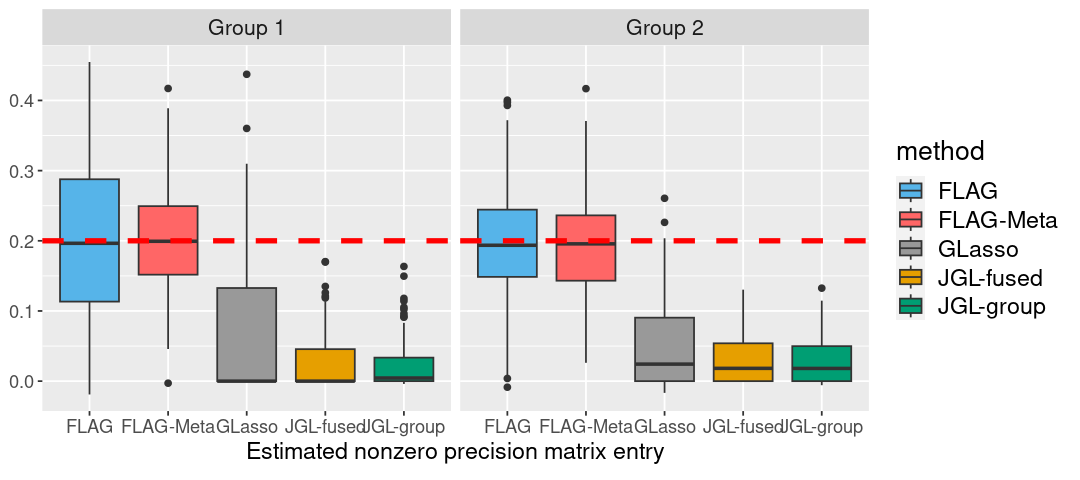

In [8]:
method_list = c('FLAG', 'FLAG-Meta', 'GLasso', 'JGL-fused', 'JGL-group')
est1 = reshape2::melt(res1.entry[, method_list])
# est1$pair=("Group 1: nonzero precision of pair(1,2)")
est1$pair=("Group 1")
est2 = reshape2::melt(res2.entry[, method_list])
est2$pair=("Group 2")
est = rbind(est1, est2)
options(repr.plot.width=9, repr.plot.height=4)
colnames(est)[2] = 'method'
ggplot(subset(est), aes(x = method, y=value, fill = method)) +
  geom_boxplot() + facet_wrap(.~pair, nrow=1) +
  geom_hline(yintercept = 0.2, lty = "dashed", color='red', size=1.5) +
#   xlab(TeX("Estimated precision matrix entry $\\Theta_{17}$")) + ylab(NULL) +
  xlab(TeX("Estimated nonzero precision matrix entry")) + ylab(NULL) +
  scale_fill_manual(labels=method_list, values = c("#56B4E9","#FF6666", "#999999", "#E69F00","#009E73"))  +
  theme(text = element_text(size = 16), legend.text = element_text(size = 14),
        axis.text = element_text(size = 11),axis.title = element_text(size = 14))

In [9]:
colMeans(err)

1_OM_fdr 1_OM_meta_fdr      1_glasso       1_fused       1_group 
    0.4134951     0.3278411     0.4136630     0.3372733     0.3434292 
     2_OM_fdr 2_OM_meta_fdr      2_glasso       2_fused       2_group 
    0.3494524     0.2924871     0.3713777     0.3065364     0.3119260

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1



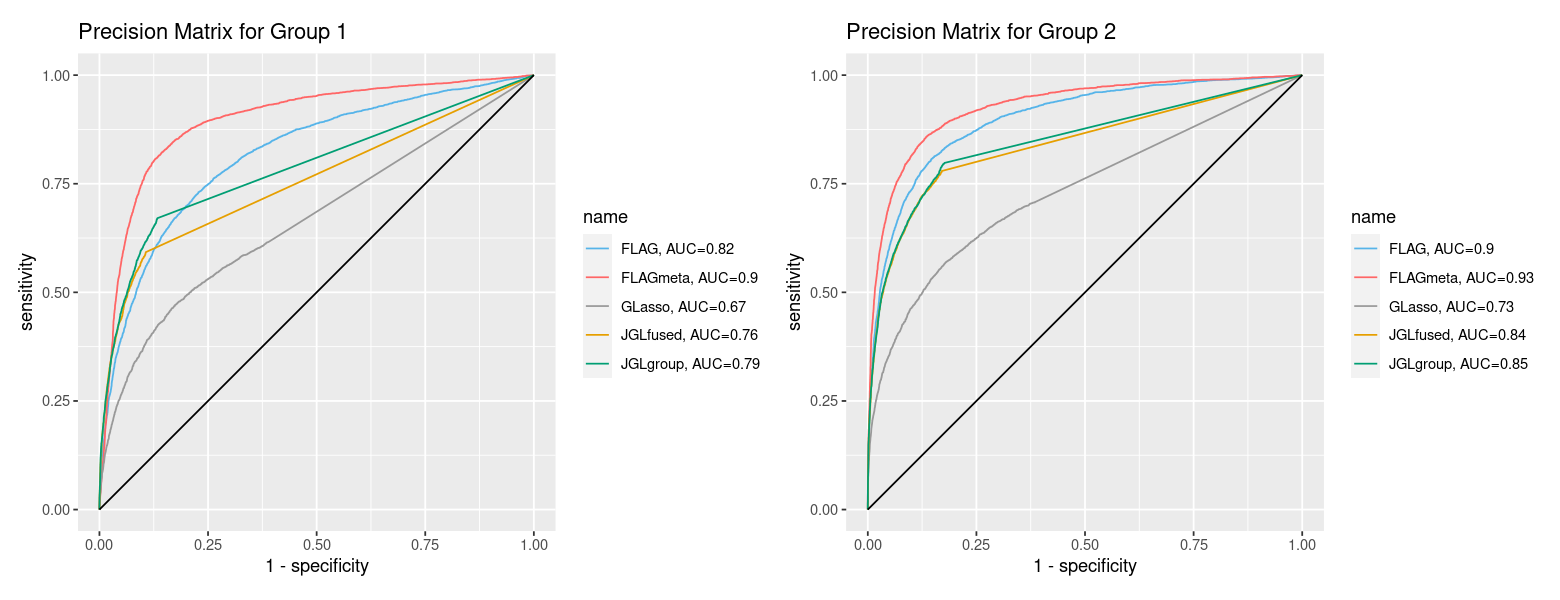

In [10]:
roc1 = list()
adj1.true = rep(get.tri(Pre1.adj), rep.times)
roc1$FLAG=roc(response=adj1.true, predictor=abs( om.list1 ), direction = "<")
roc1$FLAGmeta=roc(response=adj1.true, predictor=abs( om.meta.list1 ), direction = "<")
roc1$GLasso=roc(response=adj1.true, predictor=abs( glasso.list1 ), direction = "<")
roc1$JGLfused=roc(response=adj1.true, predictor=abs( fgl.list1 ), direction = "<")
roc1$JGLgroup=roc(response=adj1.true, predictor=abs( ggl.list1 ), direction = "<")

roc2 = list()
adj2.true = rep(get.tri(Pre2.adj), rep.times)
roc2$FLAG=roc(response=adj2.true, predictor=abs( om.list2 ), direction = "<")
roc2$FLAGmeta=roc(response=adj2.true, predictor=abs( om.meta.list2 ), direction = "<")
roc2$GLasso=roc(response=adj2.true, predictor=abs( glasso.list2 ), direction = "<")
roc2$JGLfused=roc(response=adj2.true, predictor=abs( fgl.list2 ), direction = "<")
roc2$JGLgroup=roc(response=adj2.true, predictor=abs( ggl.list2 ), direction = "<")

options(repr.plot.width=13, repr.plot.height=5)
ggroc(roc1, legacy.axes=TRUE)+ annotate(geom='segment', x=0, y=0, xend=1, yend=1) +
  scale_colour_manual(labels=get.roc.labels(roc1),values = c("#56B4E9","#FF6666", "#999999", "#E69F00","#009E73"))+
  ggtitle('Precision Matrix for Group 1')+ coord_fixed() +
ggroc(roc2, legacy.axes=TRUE)+ annotate(geom='segment', x=0, y=0, xend=1, yend=1) +
  scale_colour_manual(labels=get.roc.labels(roc2),values = c("#56B4E9","#FF6666", "#999999", "#E69F00","#009E73"))+
  ggtitle('Precision Matrix for Group 2')+ coord_fixed()